## Neural Style Transfer
---------------------------------------
 

In [1]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
! ls

gdrive	sample_data


Загрузим картинки стилей и контента

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_1_img = image_loader("gdrive/My Drive/Colab Notebooks/images/style_3.jpg")
style_2_img = image_loader("gdrive/My Drive/Colab Notebooks/images/style_5.jpg")
content_img = image_loader("gdrive/My Drive/Colab Notebooks/images/content_3.jpg")

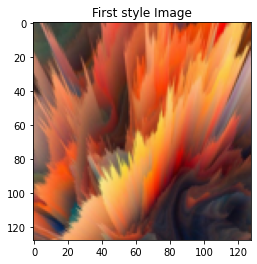

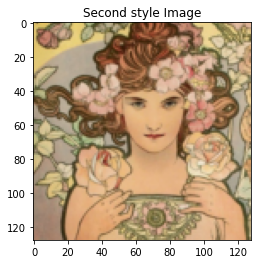

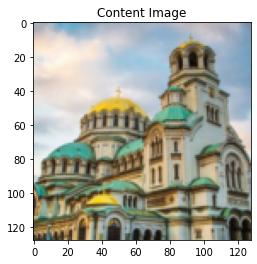

In [8]:
unloader = transforms.ToPILImage() 

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_1_img, title='First style Image')

plt.figure()
imshow(style_2_img, title='Second style Image')

plt.figure()
imshow(content_img, title='Content Image')

Сначала решим задачу одновременного применения двух стилей

In [9]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            self.target = target.detach()
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [10]:
def gram_matrix(input):
        batch_size, h, w, f_map_num = input.size()
        features = input.view(batch_size * h, w * f_map_num)
        G = torch.mm(features, features.t())

        return G.div(batch_size * h * w * f_map_num)

В этом случае функция лосса будет зависеть от параметра ratio, определяющего влияние первого стиля \\
Если ratio = 0.5, то оба стиля будут равнозначны

In [29]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature_1, target_feature_2, ratio):
            super(StyleLoss, self).__init__()
            self.target_1 = gram_matrix(target_feature_1).detach()
            self.target_2 = gram_matrix(target_feature_2).detach()
            self.ratio = ratio
            self.loss = F.mse_loss(self.target_1, self.target_1) * ratio 
            self.loss += F.mse_loss(self.target_2, self.target_2) * (1 - ratio)

        def forward(self, input):
            G = gram_matrix(input)
            self.loss = self.ratio * F.mse_loss(G, self.target_1)
            self.loss += F.mse_loss(G, self.target_2) * (1 - self.ratio)
            return input

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [13]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            return (img - self.mean) / self.std

In [14]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [16]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_1_img, style_2_img, content_img,
                                   ratio=0.5,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        normalization = Normalization(normalization_mean, normalization_std).to(device)

        content_losses = []
        style_losses = []

        model = nn.Sequential(normalization)

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature_1 = model(style_1_img).detach()
                target_feature_2 = model(style_2_img).detach()
                style_loss = StyleLoss(target_feature_1, target_feature_2, ratio)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [17]:
def get_input_optimizer(input_img):
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [18]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_1_img, style_2_img, input_img, num_steps=500,
                        style_weight=100000, content_weight=1, ratio=0.5):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_1_img, style_2_img, content_img, ratio)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        input_img.data.clamp_(0, 1)

        return input_img

Применение двух стилей (ratio = 0.5)

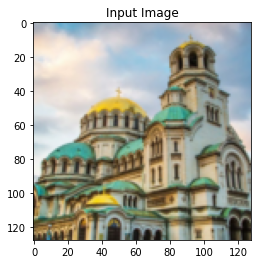

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..
run [50]:
Style Loss : 813.205750 Content Loss: 19.061907

run [100]:
Style Loss : 796.629089 Content Loss: 16.524109

run [150]:
Style Loss : 792.803162 Content Loss: 15.007790

run [200]:
Style Loss : 791.324646 Content Loss: 14.090096

run [250]:
Style Loss : 790.622742 Content Loss: 13.454249

run [300]:
Style Loss : 790.224854 Content Loss: 13.003601

run [350]:
Style Loss : 789.988220 Content Loss: 12.687033

run [400]:
Style Loss : 789.872009 Content Loss: 12.470387

run [450]:
Style Loss : 789.829895 Content Loss: 12.344517

run [500]:
Style Loss : 789.815491 Content Loss: 12.384150



In [ ]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_1_img, style_2_img, input_img)

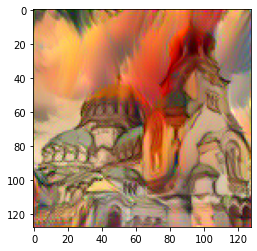

In [ ]:
imshow(output)
plt.ioff()
plt.show()

Теперь увеличим влияние первого стиля (ratio = 0.7)

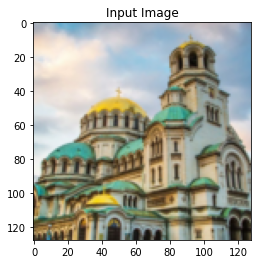

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..
run [50]:
Style Loss : 700.677063 Content Loss: 23.349226

run [100]:
Style Loss : 671.776550 Content Loss: 21.101957

run [150]:
Style Loss : 667.645874 Content Loss: 18.653114

run [200]:
Style Loss : 666.040771 Content Loss: 17.361801

run [250]:
Style Loss : 665.218750 Content Loss: 16.598515

run [300]:
Style Loss : 664.810486 Content Loss: 16.121260

run [350]:
Style Loss : 664.571411 Content Loss: 15.845373

run [400]:
Style Loss : 664.463318 Content Loss: 15.635757

run [450]:
Style Loss : 664.401428 Content Loss: 15.486883

run [500]:
Style Loss : 664.407532 Content Loss: 15.384438



In [ ]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_1_img, style_2_img, input_img, ratio=0.7)

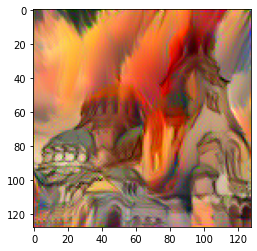

In [ ]:
imshow(output)
plt.ioff()
plt.show()

Если поставить ratio = 0, то будет применяться только второй стиль

In [ ]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_1_img, style_2_img, input_img, ratio=0)

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..
run [50]:
Style Loss : 11.845683 Content Loss: 14.294503

run [100]:
Style Loss : 5.733006 Content Loss: 11.776679

run [150]:
Style Loss : 4.070825 Content Loss: 10.548265

run [200]:
Style Loss : 3.424427 Content Loss: 9.926887

run [250]:
Style Loss : 3.071958 Content Loss: 9.544394

run [300]:
Style Loss : 2.860983 Content Loss: 9.327923

run [350]:
Style Loss : 2.741784 Content Loss: 9.190948

run [400]:
Style Loss : 2.676401 Content Loss: 9.102889

run [450]:
Style Loss : 2.642571 Content Loss: 9.038316

run [500]:
Style Loss : 2.619853 Content Loss: 8.993046



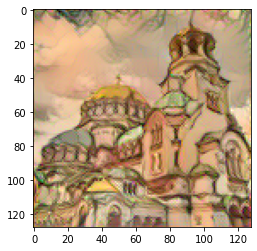

In [ ]:
imshow(output)
plt.ioff()
plt.show()

Добавим новые стили и картинки

In [30]:
style_3_img = image_loader("gdrive/My Drive/Colab Notebooks/images/style_6.jpg")
style_4_img = image_loader("gdrive/My Drive/Colab Notebooks/images/style_7.jpg")
style_5_img = image_loader("gdrive/My Drive/Colab Notebooks/images/style_4.jpg")
content_2_img = image_loader("gdrive/My Drive/Colab Notebooks/images/content_6.jpg")

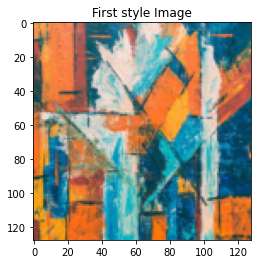

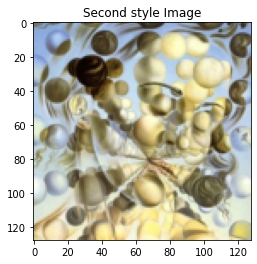

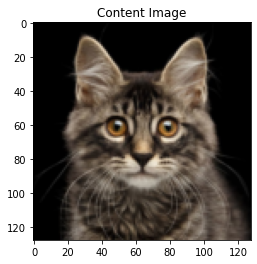

In [31]:
plt.figure()
imshow(style_5_img, title='First style Image')

plt.figure()
imshow(style_4_img, title='Second style Image')

plt.figure()
imshow(content_2_img, title='Content Image')

В этот раз на вход подадим белый шум

In [ ]:
input_img = torch.randn(content_img.data.size(), device=device)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_2_img, style_5_img, style_4_img, input_img)

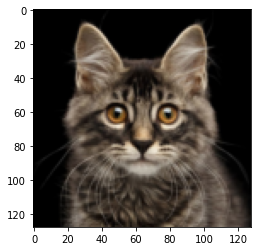

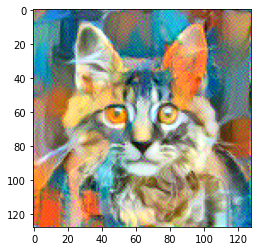

In [33]:
imshow(content_2_img)
imshow(output)
plt.ioff()
plt.show()

Теперь решим задачу применения разных стилей к разным частям картинки. Для этого переопределим функцию лосса.

In [25]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature_1, target_feature_2, ratio):
            super(StyleLoss, self).__init__()

            batch_size, h, w, f_map_num = target_feature_1.size()
            mask = target_feature_1 * 0
            mask[:, :, int(w / 2), :] = 1
            mask = mask.cumsum(dim=2)

            self.target_1 = gram_matrix(target_feature_1 * mask).detach()
            self.target_2 = gram_matrix(target_feature_2 * (1 - mask)).detach()

            self.loss = F.mse_loss(self.target_1, self.target_1) * 0.5 
            self.loss += F.mse_loss(self.target_2, self.target_2) * 0.5

        def forward(self, input):
            batch_size, h, w, f_map_num = input.size()
            mask = input * 0
            mask[:, :, int(w / 2), :] = 1
            mask = mask.cumsum(dim=2)
            input_1 = input * mask
            input_2 = input * (1 - mask)

            G_1 = gram_matrix(input_1)
            G_2 = gram_matrix(input_2)
            self.loss = F.mse_loss(G_1, self.target_1) * 0.5
            self.loss += F.mse_loss(G_2, self.target_2) * 0.5
            return input

Запустим обучение

In [26]:
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_2_img, style_1_img, input_img)

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Optimizing..
run [50]:
Style Loss : 24.313885 Content Loss: 18.055275

run [100]:
Style Loss : 8.106732 Content Loss: 17.232296

run [150]:
Style Loss : 5.625537 Content Loss: 15.776706

run [200]:
Style Loss : 4.662363 Content Loss: 15.117303

run [250]:
Style Loss : 4.294575 Content Loss: 14.705316

run [300]:
Style Loss : 4.135128 Content Loss: 14.501349

run [350]:
Style Loss : 4.111293 Content Loss: 14.421475

run [400]:
Style Loss : 3.982492 Content Loss: 14.271097

run [450]:
Style Loss : 4.085927 Content Loss: 14.216011

run [500]:
Style Loss : 4.138325 Content Loss: 14.235685



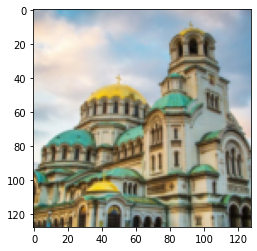

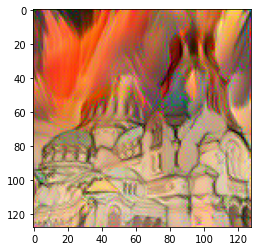

In [28]:
imshow(content_img)
imshow(output)
plt.ioff()
plt.show()

In [ ]:
input_img = torch.randn(content_img.data.size(), device=device)
output_4 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_1_img, style_2_img, input_img)

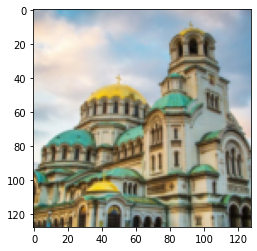

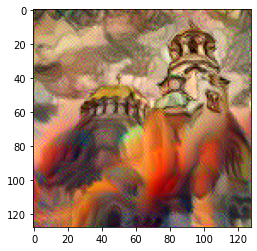

In [ ]:
imshow(content_img)
imshow(output_4)
plt.ioff()
plt.show()